In [1]:
import numpy as np
import string
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

In [2]:
import seaborn as sns 
import matplotlib.pyplot as plt


In [3]:
df_7 = pd.read_csv('qald-7-train.csv')
df_7_t = pd.read_csv('qald-7-test.csv')

df_8 = pd.read_csv('qald-8-train.csv')
df_8_t = pd.read_csv('qald-8-test.csv')

In [4]:
df = pd.concat([df_7, df_7_t,df_8,df_8_t], ignore_index=True)

In [5]:
df=df.dropna(subset=['questions'])

In [7]:
df.shape

(3834, 2)

In [9]:
df["lang"].unique()

array(['en', 'pt_BR', 'de', 'es', 'it', 'fr', 'nl', 'hi_IN', 'ro', 'fa'],
      dtype=object)

In [11]:
# English, German, Spanish, Italian, French, Dutch, Romanian
# {'en': 0, 'de': 1, 'es': 2, 'it': 3, 'fr': 4, 'nl': 5, 'ro': 6}

In [11]:
columns = ['pt_BR','hi_IN','fa']
for col in columns:
    df = df[df.lang!=col]

In [12]:
def preprocess(text):
        
    preprocessed_text = text.lower().replace('-', ' ')
    
    translation_table = str.maketrans('\n', ' ', string.punctuation+string.digits)
    
    preprocessed_text = preprocessed_text.translate(translation_table)
        
    return preprocessed_text

In [13]:
df['questions'] = [preprocess(text) for text in df['questions'].values]

In [18]:
# df_train.head()

In [19]:
# subwords

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['questions'],
    df['lang'],
    test_size=0.20,
    shuffle=True,
    stratify=df['lang'],
    random_state=7
)

In [15]:
# taken from https://arxiv.org/abs/1508.07909

import re, collections
from collections import defaultdict
def get_stats(vocab):
    pairs = collections.defaultdict(int) 
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq 
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word] 
    return v_out

In [16]:
def get_vocab(data):

    words = []
    for sentence in data:
        words.extend(sentence.split())
        
    vocab = defaultdict(int)
    for word in words:
        vocab[' '.join(word)] += 1
        
    return vocab

In [17]:
X_train

2783           quelle est la plus grande ville daustralie
2328     liste alle musicals mit musik von elton john auf
3339           quel est lindicatif téléphonique de berlin
3522                  who is the founder of penguin books
1409                quel est le pays dorigine de sitecore
                              ...                        
1273    cine este pilotul de curse formula  cu cele ma...
3607            chi sono i genitori della regina vittoria
3069                  welke stad heeft de meeste inwoners
1735    gib mir alle bücher von william goldman mit me...
3345    dammi tutti gli attori che hanno recitato in l...
Name: questions, Length: 2440, dtype: object

In [18]:
vocab = get_vocab(X_train)

In [19]:
# also taken from original paper
for i in range(100):
    pairs = get_stats(vocab)
    best = max(pairs, key=pairs.get) 
    vocab = merge_vocab(best, vocab)

In [20]:
merges = defaultdict(int)
for k, v in vocab.items():
    for subword in k.split():
        if len(subword) >= 2:
            merges[subword] += v

In [21]:
merge_ordered = sorted(merges, key=merges.get, reverse=True)

In [30]:
# pkl.dump(merge_ordered, open('Data/Auxiliary/merge_ordered.pkl', 'wb'))

In [22]:
def split_into_subwords(text):
    merges = merge_ordered
    subwords = []
    for word in text.split():
        for subword in merges:
            subword_count = word.count(subword)
            if subword_count > 0:
                word = word.replace(subword, ' ')
                subwords.extend([subword]*subword_count)
    return ' '.join(subwords)

In [23]:
split_into_subwords('My name is Oshara')

'am is ar'

In [24]:
X_train = [split_into_subwords(text) for text in X_train.values]

In [25]:
X_test = [split_into_subwords(text) for text in X_test.values]

In [26]:
vectorizer = CountVectorizer()

In [27]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [28]:
X_train

<2440x70 sparse matrix of type '<class 'numpy.int64'>'
	with 24143 stored elements in Compressed Sparse Row format>

In [29]:
naive_classifier = MultinomialNB(fit_prior=False,alpha=0.01)
naive_classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.01, fit_prior=False)

In [30]:
predictions = naive_classifier.predict(X_test)

In [40]:
# 0.7359154929577465

In [31]:
accuracy_score(y_test, predictions)

0.8295081967213115

In [32]:
y_train.unique()

array(['fr', 'de', 'en', 'ro', 'it', 'es', 'nl'], dtype=object)

In [33]:
y_test.unique()

array(['en', 'de', 'nl', 'it', 'fr', 'es', 'ro'], dtype=object)

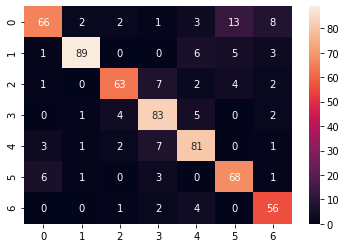

In [34]:
cm = confusion_matrix(y_test,predictions)
sns.heatmap(cm,annot=True,fmt="d");